In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pyfits
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import speclite.filters as spec

In [2]:
cosmo = FlatLambdaCDM(Om0=0.3, H0=70)

In [3]:
kcorr = pyfits.open("templates/k_nmf_derived.default.fits")

seds = kcorr[1].data
kcorr_wave = kcorr[11].data

In [4]:
# change seds from erg/s/cm^2/A to uJy
# lambda^2 / c * 1e29
for i in range(5):
    seds[i,:] = seds[i,:] * ((kcorr_wave*kcorr_wave*1e-10)/2.99e8) * 1e29

In [5]:
path_local = "/Users/philipp/Documents/PhD/Data/"
path_lustre = "/mnt/lustre/psudek/data/"
cat = pyfits.open(path_lustre+"COSMOS2020_Classic_processed.fits")[1].data
eazy_cosmos = pyfits.open("eazy-out/Cosmos/cosmos.eazypy.data.fits")
coeff = eazy_cosmos[4].data
print(coeff)

[[0.0000000e+00 2.7396938e+17 1.4511535e+20 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 8.9475281e+17 0.0000000e+00 0.0000000e+00 1.1636854e+20]
 [0.0000000e+00 8.5966966e+17 4.5316943e+20 0.0000000e+00 0.0000000e+00]
 ...
 [5.6317373e+21 5.6765493e+18 5.5670939e+19 0.0000000e+00 7.0438613e+20]
 [4.9741497e+22 0.0000000e+00 4.5252937e+21 3.2416795e+23 0.0000000e+00]
 [5.5101726e+22 4.1738926e+19 2.1916461e+22 1.0508482e+23 1.0231709e+22]]


In [6]:
print(len(cat))
print(len(coeff))

723897
723897


In [7]:
mask = np.where((23.9-2.5*np.log10(cat['UVISTA_Ks_FLUX_APER3'])<25.5)&(cat['photoz']>0))[0]

cat = cat[mask]
coeff = coeff[mask]
print(len(cat))

/users/psudek/virtual_environments/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


441277


In [8]:
filt_name = np.array(['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 
             'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 
             'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 
             'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 
             'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4'])  
filt_lambda = 1e4*np.array([0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,
                            1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,
                            0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,
                            0.8978,0.9063,3.5686,4.5067,5.7788,7.9958])

In [9]:
use_filt = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12, 28])
filt_name[use_filt]

array(['HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y',
       'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_B'], dtype='<U12')

In [10]:
W21_phot = np.array([cat["{}_FLUX_APER3".format(band)] for band in filt_name[use_filt]]).T
W21_err = np.array([cat["{}_FLUXERR_APER3".format(band)] for band in filt_name[use_filt]]).T

# There are some -99's in this cat, that I think should be NaNs
W21_phot[W21_phot==-99.] = np.nan

# restrict lambda to chosen filters
W21_lam = filt_lambda[use_filt]

In [11]:
ob = 50020
print(cat['photoz'][ob])
print(coeff[ob,:], np.sum(coeff[ob,:]))
# print(coeff[ob,:]*amps, np.sum(coeff['coeffs'][ob,:]*amps))

1.9993
[0.0000000e+00 1.5798376e+17 2.2072759e+20 7.0534339e+19 0.0000000e+00] 2.9141991e+20


In [12]:
sed = np.sum(seds.T*coeff[ob,:], axis=1)
wave_mask = np.where((kcorr_wave*(1+cat['photoz'][ob])>3300)&(kcorr_wave*(1+cat['photoz'][ob])<50000))[0]

In [13]:
a = 1./1.011705685618729e+29 # where is this coming from?h7

In [14]:
# plt.rc('font',**{'family':'serif','size':14})
# plt.rc('text', usetex=True)

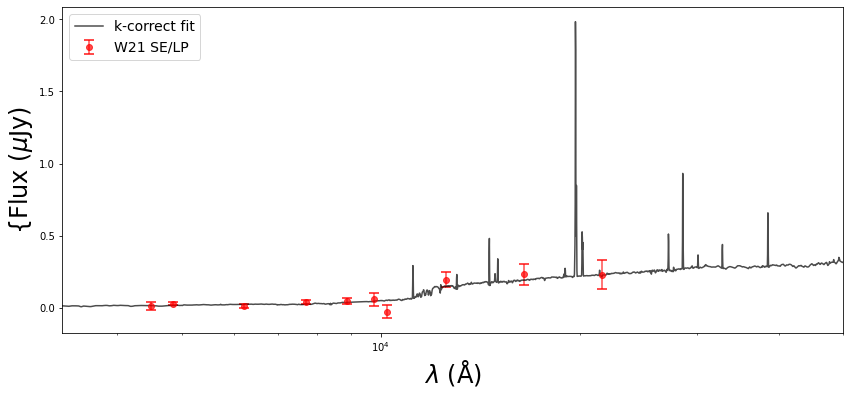

In [15]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\lambda$ (${\rm \AA}$)', fontsize=24)
ax.set_ylabel(r'{Flux ($\mu$Jy)', fontsize=24)
ax.set_xscale('log')

ax.errorbar(W21_lam, W21_phot[ob,:], yerr=W21_err[ob,:], marker='o', c='r', 
            label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

ax.plot(kcorr_wave[wave_mask]*(1+cat['photoz'][ob]), sed[wave_mask]*a, 'k-', alpha=0.7, label='k-correct fit')

ax.set_xlim([3300.,50000.])
ax.legend(fontsize=14, loc=2)
plt.show()

(array([9175]),)
[1577098.5]


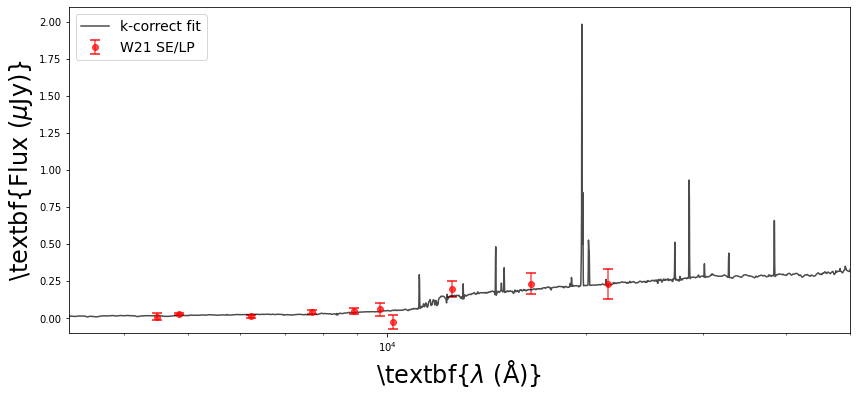

In [16]:
print(np.where(sed*a == max(sed*a)))
print(kcorr_wave[np.where(sed*a == max(sed*a))])
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{$\lambda$ (${\rm \AA}$)}', fontsize=24)
ax.set_ylabel(r'\textbf{Flux ($\mu$Jy)}', fontsize=24)
ax.set_xscale('log')

ax.errorbar(W21_lam, W21_phot[ob,:], yerr=W21_err[ob,:], marker='o', c='r', 
            label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

ax.plot(kcorr_wave*(1+cat['photoz'][ob]), sed*a, 'k-', alpha=0.7, label='k-correct fit')

ax.set_ylim([-0.1, 2.1])
ax.set_xlim([3300.,50000.])
ax.legend(fontsize=14, loc=2)
plt.show()

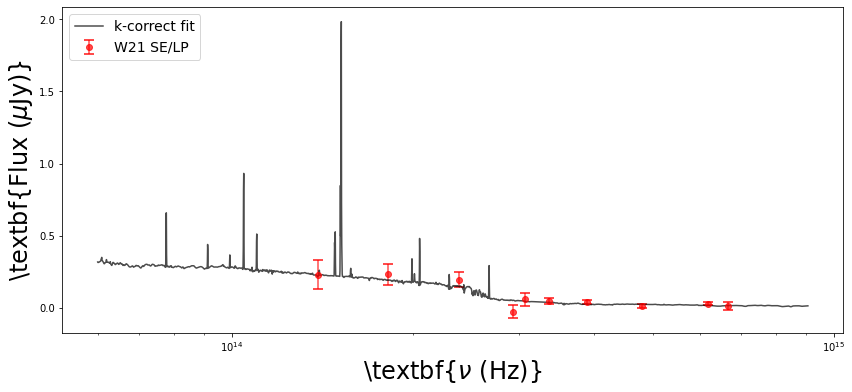

In [17]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{$\nu$ (Hz)}', fontsize=24)
ax.set_ylabel(r'\textbf{Flux ($\mu$Jy)}', fontsize=24)
ax.set_xscale('log')

ax.errorbar(2.99e8 / (W21_lam*10**(-10)), W21_phot[ob,:], yerr=W21_err[ob,:], marker='o', c='r', 
            label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

ax.plot(2.99e8 / (kcorr_wave[wave_mask]*(1+cat['photoz'][ob])*10**(-10)), sed[wave_mask]*a, 'k-', alpha=0.7, label='k-correct fit')

#ax.set_xlim([2.99e8/(3300.**10**(-10)),2.99e8/(50000.*10**(-10))])
ax.legend(fontsize=14, loc=2)
plt.show()

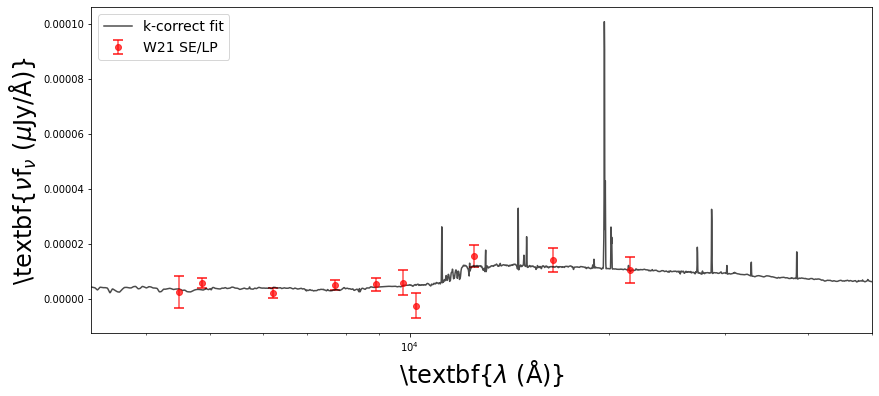

In [18]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{$\lambda$ (${\rm \AA}$)}', fontsize=24)
ax.set_ylabel(r'\textbf{$\nu$f$_{\nu}$ ($\mu$Jy/${\rm \AA}$)}', fontsize=24)
ax.set_xscale('log')

ax.errorbar(W21_lam, W21_phot[ob,:]/W21_lam, yerr=W21_err[ob,:]/W21_lam, marker='o', c='r', 
            label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

ax.plot(kcorr_wave[wave_mask]*(1+cat['photoz'][ob]), 
        sed[wave_mask]*a/(kcorr_wave[wave_mask]*(1+cat['photoz'][ob])), 
        'k-', alpha=0.7, label='k-correct fit')

ax.set_xlim([3300.,50000.])
ax.legend(fontsize=14, loc=2)
plt.show()

### Calculate K-Corrections

In [19]:
def k_correction(sed, wave_observed, redshift, filter_abs, filter_app):
    '''Calculate the k-correction between AB-magnitudes.
    sed: array_like
        Observed flux as a function of observed wavelength.
    wave_observed: array_like
        Observed wavelength in Angstrom.
    redshift: float or array_like
        Redshift of the object.
    filter_abs, filter_app: speclite response object
        The bandpasses of the K-correction
    '''

    wave_emitted = (wave_observed.T / (1+redshift)).T

    frequency_emitted = 2.99e8 / (wave_emitted*10**(-10))
    frequency_observed = 2.99e8 / (wave_observed*10**(-10))

    
    response_emitted = np.interp(wave_emitted, filter_abs.wavelength, filter_abs.response) \
                        * 2.99e8 / wave_emitted**2
    response_observed = np.interp(wave_observed, filter_app.wavelength, filter_app.response) \
                        * 2.99e8 / wave_observed**2
    int_sed_observed = np.sum(1./frequency_observed * sed * response_observed, axis=-1)

    int_sed_emitted = np.sum(1./frequency_emitted * sed * response_emitted, axis=-1)
    
    AB_zero = 3631 * 10**6 # in muJy and frequency space
    norm_observed = np.sum(1./frequency_observed * AB_zero * response_observed)
    norm_emitted = np.sum(1./frequency_emitted * AB_zero * response_emitted)
    
    return -2.5 * np.log10((1+redshift) * int_sed_observed/norm_observed * norm_emitted/int_sed_emitted)

def k_correction_interp_before_int_ratio(kcorr_templates, kcorr_wave, redshift, filter_abs, filter_app, coeffs):
    # shape coeff (redshift, 5)
    # cause the integral ratio decreases rapidly with small redshifts
    z_grid = np.geomspace(min(redshift), max(redshift), 1000) 
    z_grid = np.geomspace(0.01, 3, 100) 
    wave_observed = kcorr_wave * (1+z_grid[:, np.newaxis])
    
    frequency_emitted = 2.99e8 / (kcorr_wave*10**(-10))
    frequency_observed = 2.99e8 / (wave_observed*10**(-10))

    response_emitted = np.interp(kcorr_wave, filter_abs.wavelength, filter_abs.response) \
                        * 2.99e8 / kcorr_wave**2 # shape kcorr_wave
    response_observed = np.interp(wave_observed, filter_app.wavelength, filter_app.response) \
                        * 2.99e8 / wave_observed**2 # shape (z_grid, kcorr_wave)

    int_sed_observed = np.trapz(1./frequency_observed[..., np.newaxis] * kcorr_templates.T * 
                                response_observed[..., np.newaxis], 
                                frequency_observed[..., np.newaxis], axis=1) # shape (z_grid, coeff[0])
    
    int_z_observed = np.zeros((len(coeffs[0]), len(redshift)))
    for i in range(len(coeffs[0])):
        int_z_observed[i] = np.interp(redshift, z_grid, int_sed_observed[:,i])
    int_sed_observed = np.sum(coeffs*int_z_observed.T, axis=-1)

    int_sed_emitted = np.trapz(1./frequency_emitted[..., np.newaxis] * kcorr_templates.T * 
                               response_emitted[..., np.newaxis], 
                               frequency_emitted, axis=0) # shape coeff[0]
    int_sed_emitted = np.sum(coeffs*int_sed_emitted, axis=-1)

    
    AB_zero = 3631 * 10**6 # in muJy and frequency space

    norm_observed = np.trapz(1./frequency_observed * AB_zero * response_observed, frequency_observed, axis=-1) # shape z_grid
    norm_observed = np.interp(redshift, z_grid, norm_observed)
    norm_emitted = np.trapz(1./frequency_emitted * AB_zero * response_emitted, frequency_emitted, axis=-1) # shape ()
    
    return -2.5 * np.log10((1+redshift) * int_sed_observed/norm_observed * norm_emitted/int_sed_emitted)
    

In [20]:
i_band = spec.load_filter('hsc2017-i')
B_band = spec.load_filter('bessell-B')

In [21]:
indices = np.random.choice(len(cat), size=2, replace=False)
cat_reduced = cat[indices]
coeff_reduced = coeff[indices,:]

In [22]:
seds_cat = np.zeros((len(cat_reduced), len(kcorr_wave)))
wave = np.zeros((len(cat_reduced), len(kcorr_wave)))
for i in range(len(cat_reduced)):
    seds_cat[i] = np.sum(seds.T*coeff_reduced[i,:], axis=1)*a
    wave[i] = kcorr_wave*(1+cat_reduced['photoz'][i])
    print(k_correction(seds_cat[i], wave[i], cat_reduced['photoz'][i], B_band, i_band))

-0.12975759330585038
-1.253700281500122


In [23]:
kcorrections = k_correction(seds_cat, wave, cat_reduced['photoz'], B_band, i_band)
print(kcorrections)

[-0.1296675  -1.25379037]


In [24]:
# get seds and wavelenghts broadcasting
seds_cat = np.sum(seds*coeff_reduced[:,:,np.newaxis], axis=1) * a
wave = kcorr_wave*(1+cat_reduced['photoz'][:,np.newaxis])

In [25]:
kcorrections = k_correction(seds_cat, wave, cat_reduced['photoz'], B_band, i_band)

In [26]:
print(cat_reduced['photoz'])
print(kcorrections)

[3.3006 0.2743]
[-0.12966749 -1.25379039]


In [27]:
d = np.array([[1,1,1],[2,2,2]])
print(d.shape)
print(d.sum(axis=0), d.sum(axis=0).shape)
print(d.sum(axis=1), d.sum(axis=1).shape)
print(d.sum(axis=-1), d.sum(axis=-1).shape)
print('#####')
d = np.array([1,1,1])
print(d.sum())
print(d.sum(axis=0))
print(d.sum(axis=-1))

(2, 3)
[3 3 3] (3,)
[3 6] (2,)
[3 6] (2,)
#####
3
3
3


### Get absolute magnitudes for all galaxies

Because of memory reasons I will calculate them in a loop

In [28]:
abs_mag = np.zeros(len(cat))
k_correct = np.zeros(len(cat))
for i in range(len(cat)):
    seds_cat = np.sum(seds.T*coeff[i,:], axis=1)*a
    wave = kcorr_wave*(1+cat['photoz'][i])
    k_correct[i] = k_correction(seds_cat, wave, cat['photoz'][i], B_band, i_band)
    abs_mag[i] = cat['HSC_i_MAG_APER3'][i] - cosmo.distmod(cat['photoz'][i]).value - k_correct[i]

/users/psudek/virtual_environments/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


In [29]:
k_correct_interp = k_correction_interp_before_int_ratio(seds, kcorr_wave, cat['photoz'], B_band, i_band, coeff)
abs_mag_interp = cat['HSC_i_MAG_APER3'] - cosmo.distmod(cat['photoz']).value - k_correct_interp

/users/psudek/virtual_environments/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


In [30]:
print(abs_mag)
print(abs_mag_interp)

[-18.24432595 -16.67581376 -17.83201758 ... -22.49578833 -20.43321895
 -20.91989761]
[-18.25138586 -16.66607882 -17.83424082 ... -22.47680407 -20.41033181
 -20.91016001]


In [31]:
len(cat['HSC_i_MAG_APER3'][np.isnan(cat['HSC_i_MAG_APER3'])])

311

In [32]:
len(abs_mag[np.isnan(abs_mag)])

357

In [33]:
mag_hist, bin_edges = np.histogram(abs_mag, bins=100, range=(-28,0))
bin_centers = bin_edges[:-1] + (bin_edges[-1]-bin_edges[0])/(2*len(bin_edges))

mag_hist_interp, _ = np.histogram(abs_mag_interp, bins=bin_edges, range=(-28,0))

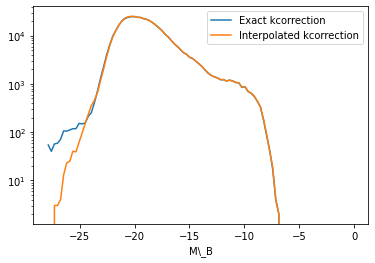

In [34]:
plt.plot(bin_centers, mag_hist, label="Exact kcorrection")
plt.plot(bin_centers, mag_hist_interp, label="Interpolated kcorrection")
plt.xlabel("M\_B")
plt.yscale('log')
plt.legend()
plt.show()

In [35]:
type(cat)

astropy.io.fits.fitsrec.FITS_rec

### Save absolute magnitudes into file

In [36]:
from astropy.table import Table, Column

In [37]:
col = Column(abs_mag, name='AbsMag')
t = Table()

In [38]:
t.add_column(col)

In [39]:
col = Column(k_correct, name='K-Correction')
t.add_column(col)

col = Column(abs_mag_interp, name='AbsMag Interp')
t.add_column(col)

col = Column(k_correct_interp, name='K-Correction Interp')
t.add_column(col)

In [40]:
print(len(t))
print(len(cat))

441277
441277


In [41]:
t.write(path_lustre+"Cosmos_Classic_absolute_mags.fits", format='fits', overwrite=True)

### Plot and save the luminosity function

In [42]:
mask = np.where((cat['photoz']>0) &
                (cat['photoz']<8.) &
                 (23.9-2.5*np.log10(cat['UVISTA_Ks_FLUX_APER3'])<24.5) &
                (cat['lp_type']==0))[0]
cat = cat[mask]
abs_mag = abs_mag[mask]
k_correct = k_correct[mask]
abs_mag_interp = abs_mag_interp[mask]
k_correct_interp = k_correct_interp[mask]
print(len(cat))

261209


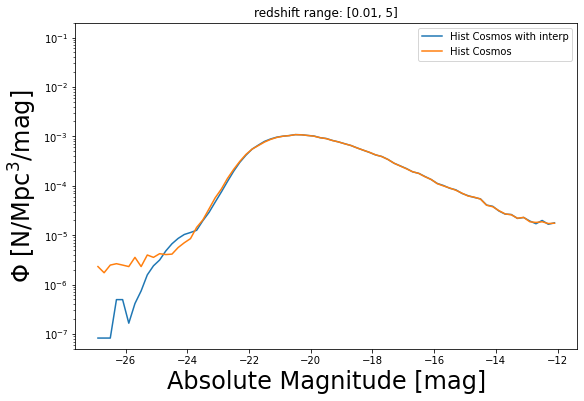

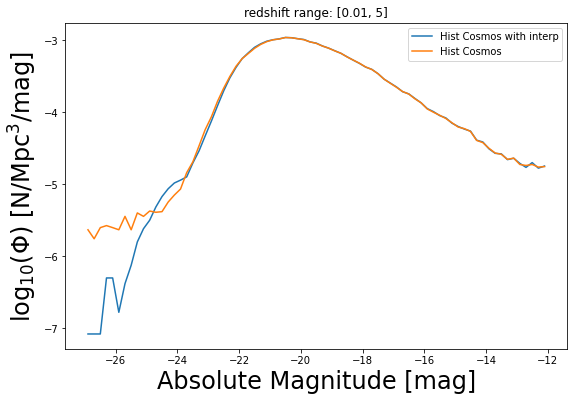

     M_bin_left         M_bin_right     ...          Phi          
------------------- ------------------- ... ----------------------
              -27.0               -26.8 ... 2.3095673818135866e-06
              -26.8               -26.6 ...   1.73217553636019e-06
              -26.6 -26.400000000000002 ... 2.4745364805145572e-06
-26.400000000000002 -26.200000000000003 ... 2.6395055792155274e-06
-26.200000000000003 -26.000000000000004 ... 2.4745364805145572e-06
-26.000000000000004 -25.800000000000004 ... 2.3095673818135866e-06
-25.800000000000004 -25.600000000000005 ... 3.5468356220708652e-06
-25.600000000000005 -25.400000000000006 ... 2.3095673818135866e-06
-25.400000000000006 -25.200000000000006 ... 3.9592583688232916e-06
-25.200000000000006 -25.000000000000007 ... 3.5468356220708652e-06
                ...                 ... ...                    ...
-14.200000000000045 -14.000000000000046 ...  3.753046995447079e-05
-14.000000000000046 -13.800000000000047 ... 3.1261644203833904

In [49]:
from astropy.units import Quantity
sky_area = Quantity(1.27, "deg2")
Mbins = np.arange(-27,-12+0.2,0.2)
Mmid = (Mbins[1:] + Mbins[:-1])/2.
redshift_range = [0.01, 5]
z = np.linspace(redshift_range[0], redshift_range[1], 100)

z_mask = np.logical_and(cat['photoz'] >= redshift_range[0], cat['photoz'] < redshift_range[1])
dV_dz = (cosmo.differential_comoving_volume(z) * sky_area).to_value('Mpc3')
dV = np.trapz(dV_dz, z)
dM = (np.max(Mbins)-np.min(Mbins)) / (np.size(Mbins)-1)
phi_cosmos = np.histogram(abs_mag[z_mask], bins=Mbins)[0] / dV / dM

z_mask = np.logical_and(cat['photoz'] >= redshift_range[0], cat['photoz'] < redshift_range[1])
dV_dz = (cosmo.differential_comoving_volume(z) * sky_area).to_value('Mpc3')
dV = np.trapz(dV_dz, z)
dM = (np.max(Mbins)-np.min(Mbins)) / (np.size(Mbins)-1)
phi_cosmos_interp = np.histogram(abs_mag_interp[z_mask], bins=Mbins)[0] / dV / dM

plt.figure(figsize=(9,6))
plt.plot(Mmid, phi_cosmos_interp, label="Hist Cosmos with interp")
plt.plot(Mmid, phi_cosmos, label="Hist Cosmos")
plt.legend()
plt.xlabel(r"Absolute Magnitude [mag]", fontsize=24)
plt.ylabel(r'$\Phi$ [N/Mpc$^3$/mag]', fontsize=24)
plt.yscale('log')
plt.title(f'redshift range: {redshift_range}')
plt.ylim([5.e-8, 2.e-1])
plt.show()

plt.figure(figsize=(9,6))
plt.plot(Mmid, np.log10(phi_cosmos_interp), label="Hist Cosmos with interp")
plt.plot(Mmid, np.log10(phi_cosmos), label="Hist Cosmos")
plt.legend()
plt.xlabel(r"Absolute Magnitude [mag]", fontsize=24)
plt.ylabel(r'$\log_{10}(\Phi)$ [N/Mpc$^3$/mag]', fontsize=24)
plt.title(f'redshift range: {redshift_range}')
#plt.ylim([5.e-8, 2.e-1])
plt.show()

t = Table()
col_M_bin_left = Column(Mbins[:-1], name='M_bin_left')
col_M_bin_right = Column(Mbins[1:], name='M_bin_right')
col_M_mid = Column(Mmid, name='M_mid')
col_phi_interp = Column(phi_cosmos_interp, name='Phi_interp')
col_phi = Column(phi_cosmos, name='Phi')
t.add_columns([col_M_bin_left, col_M_bin_right, col_M_mid,
               col_phi_interp, col_phi
              ])
print(t)
t.write(path_lustre+f"Cosmos_Classic_phi_z{redshift_range[0]}:{redshift_range[1]}_mag_cut245.fits", 
        format='fits', overwrite=True)